# Logistic regression on the MNIST handwritten digits

In this miniproject, you are asked to apply logistic regression to solve the problem of handwritten digit recognition. The data set being used below is rather large in both size and dimension. To speed up computing, you can use PCA to reduce the dimension considerably. You will then apply logistic regression (no regularization) to the dimension reduced data.

Note: One could use the regularization technique (as an alternative to PCA) to handle the many features. It would also effectively handle the issue of multicollinearity but computing is rather intensive.


Import libraries

In [147]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import scipy.io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

In [148]:
warnings.filterwarnings('ignore')

load the MNIST data set (you need to first download the file mnist.mat and save it in the same place with the notebook)

In [149]:
mat = scipy.io.loadmat('../datasets/mnist.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Sep 12 14:11:18 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Xtr': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Xtst': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'ytr': array([[5],
        [0],
        [4],
        ...,
        [5],
        [6],
        [8]], dtype=uint8),
 'ytst': array([[7],
        [2],
        [1],
        ...,
        [4],
        [5],
        [6]], dtype=uint8)}

In [150]:
X_train = mat['Xtr']
y_train = mat['ytr']
X_test = mat['Xtst']
y_test = mat['ytst']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

Apply PCA to reduce the dimension from 784 to 50

In [151]:
pca50 = PCA(n_components=50).fit(X_train)

X_train_pca = pca50.transform(X_train)
X_test_pca = pca50.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((60000, 50), (10000, 50))

The following experiments are all based on the dimension reduced data (training and test).

In [152]:
def filter_digits(X, y, digits):
    mask = np.isin(y, digits).flatten()
    return X[mask], y[mask].reshape(-1)

def evaluate_model_results(y_true, y_pred, model):
    try:
        model_name = str(model.multi_class).capitalize()
    except:
        model_name = model.__class__.__name__

    score = accuracy_score(y_true, y_pred)
    error = 1 - score
    
    cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:\n",cm)
    digits = ', '.join(map(str, model.classes_))
    print(f'{digits} -> {model_name} Test Score: {score*100:.2f}%')
    print(f'{digits} -> {model_name} Test Error: {error*100:.2f}%')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
    disp.plot()
    disp.ax_.set_title(f'{digits} {model_name} Confusion Matrix')
    

def fit_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_model_results(y_true=y_test, y_pred=y_pred, model=model)

## (1) Classifying a pair of digits

First, let's consider the pair $\mathbf{\{0,1\}}$, which should be relatively easy. Train a binary logistic regression classifier on all the training images that contain either digit and evaluate the trained classifer on the test images containing one of the two digits. Display the confusion matrix. What is the overall classification error?

In [153]:
X_train_01, y_train_01 = filter_digits(X_train_pca, y_train, [0, 1])

LogisticModelfull = LogisticRegression(C=1e5,max_iter=500).fit(X_train_01, y_train_01)

In [154]:
X_test_01, y_test_01 = filter_digits(X_test_pca, y_test, [0, 1])

pred = LogisticModelfull.predict(X_test_01)

n_test_01 = y_test_01.shape[0]

accuracy_01 = np.sum(pred == y_test_01)/n_test_01
accuracy_01

0.9985815602836879

0, 1 -> Deprecated Test Score: 99.86%
0, 1 -> Deprecated Test Error: 0.14%


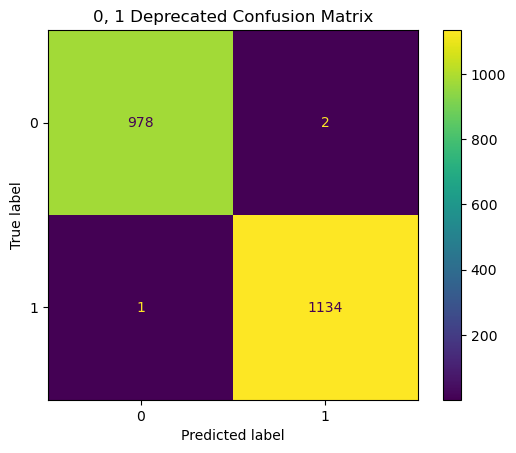

In [155]:
fit_model(X_train_01, y_train_01, X_test_01, y_test_01, LogisticModelfull)

Do the same thing with the pair $\mathbf{\{1,7\}}$ instead. How does it compare with the pair {0,1} in terms of overall error?

In [156]:
X_train_pca_1_7, y_train_1_7 = filter_digits(X_train_pca, y_train, [1, 7])
X_test_pca_1_7, y_test_1_7 = filter_digits(X_test_pca, y_test, [1, 7])

LogisticModel1_7 = LogisticRegression(C=1e5,max_iter=500).fit(X_train_pca_1_7, y_train_1_7)

pred = LogisticModel1_7.predict(X_test_pca_1_7)
n_test_17 = y_test_1_7.shape[0]

accuracy_17 = np.sum(pred == y_test_1_7.ravel())/n_test_17
accuracy_17

0.9926028663892742

1, 7 -> Deprecated Test Score: 99.26%
1, 7 -> Deprecated Test Error: 0.74%


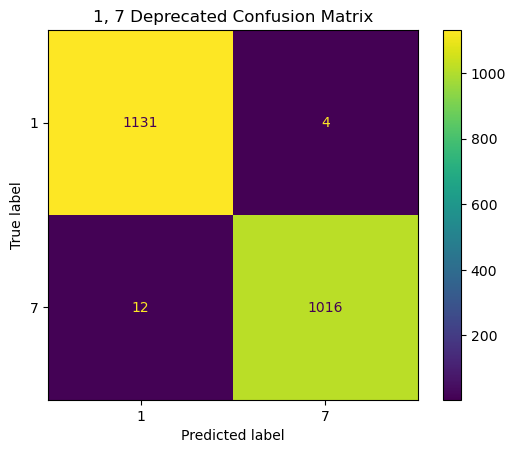

In [157]:
fit_model(X_train_pca_1_7, y_train_1_7, X_test_pca_1_7, y_test_1_7, LogisticModel1_7)

Which pair of digits do you think are the hardest to distinguish? Perform binary logistic regression with those images (training and test) and report the overall error.

#### (7 and 9 -> accuracy 95.83%), (3 and 5 -> accuracy 95.16%), (5 and 8 -> accuracy 95.55%),      

In [158]:
a = 5
b = 8
X_train_pca_a = X_train_pca[y_train.ravel()==a,:]
y_train_a = y_train[y_train.ravel()==a,:]


X_train_pca_b = X_train_pca[y_train.ravel()==b,:]
y_train_b = y_train[y_train.ravel()==b,:]


X_train_pca_ab = np.concatenate((X_train_pca_a, X_train_pca_b))
y_train_ab = np.concatenate((y_train_a, y_train_b))


LogisticModelab = LogisticRegression(C=1e5,max_iter=500).fit(X_train_pca_ab, y_train_ab.ravel())

X_test_pca_a = X_test_pca[y_test.ravel()==a,:]
y_test_a = y_test[y_test.ravel()==a,:]

X_test_pca_b = X_test_pca[y_test.ravel()==b,:]
y_test_b = y_test[y_test.ravel()==b,:]


X_test_pca_ab = np.concatenate((X_test_pca_a, X_test_pca_b))

y_test_ab = np.concatenate((y_test_a, y_test_b))

pred = LogisticModelab.predict(X_test_pca_ab)

n_test_ab = y_test_ab.shape[0]


accuracy_ab = np.sum(pred == y_test_ab.ravel())/n_test_ab

accuracy_ab

0.954983922829582

7, 9 -> Deprecated Test Score: 95.88%
7, 9 -> Deprecated Test Error: 4.12%

3, 5 -> Deprecated Test Score: 95.11%
3, 5 -> Deprecated Test Error: 4.89%

5, 8 -> Deprecated Test Score: 95.50%
5, 8 -> Deprecated Test Error: 4.50%



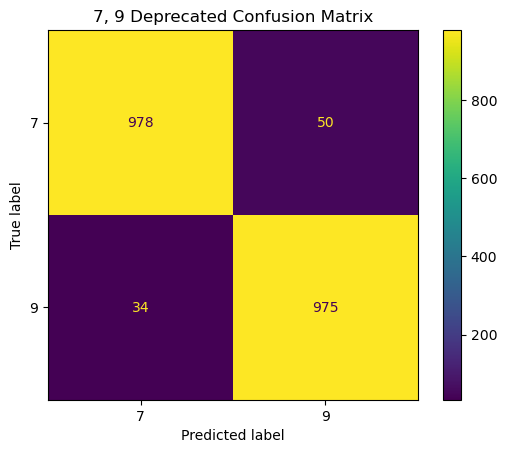

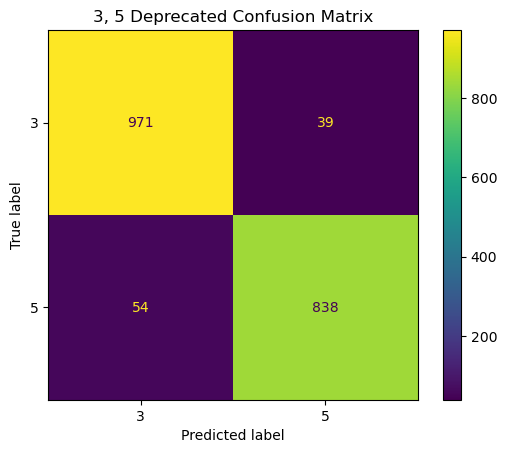

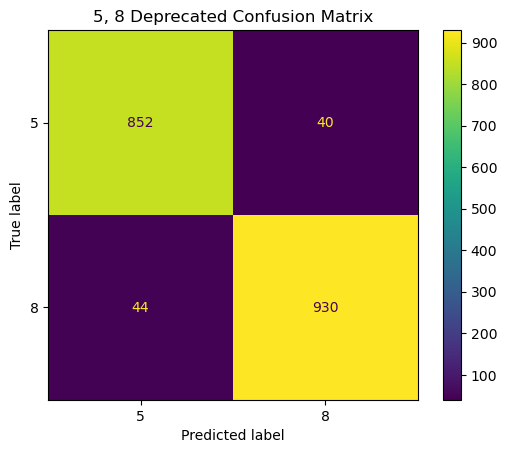

In [159]:
digits = [[7, 9], [3, 5], [5, 8]]

for digit_pair in digits:
    X_train_filter, y_train_filter = filter_digits(X_train_pca, y_train, digit_pair)
    X_test_filter, y_test_filter = filter_digits(X_test_pca, y_test, digit_pair)

    LogisticModel = LogisticRegression(C=1e5,max_iter=500).fit(X_train_filter, y_train_filter)
    
    fit_model(X_train_filter, y_train_filter, X_test_filter, y_test_filter, LogisticModel)
    print()

## (2) Classifying three digits together

Consider the triple of digits $\mathbf{\{0,1,2\}}$, which should also be relatively easy. We need to train a multiclass logistic regression classifier on all the training images that contain the three digit and evaluate the trained classifer on the test images containing one of the three digits. There are three ways to extend binary logistic regression to the multiclass setting.

(2a) Perform the $\textbf{one-versus-rest}$ multiclass logistic regression on the three digits {0,1,2} and report the overall test error.

In [160]:
digits = [0, 1, 2]

X_train_pca_filter, y_train_pca_filter = filter_digits(X_train_pca, y_train, digits)
X_test_pca_filter, y_test_pca_filter = filter_digits(X_test_pca, y_test, digits)

# Checking unique values in y_train_pca_filter
set(y_train_pca_filter)

{0, 1, 2}

0, 1, 2 -> OneVsRestClassifier Test Score: 98.54%
0, 1, 2 -> OneVsRestClassifier Test Error: 1.46%


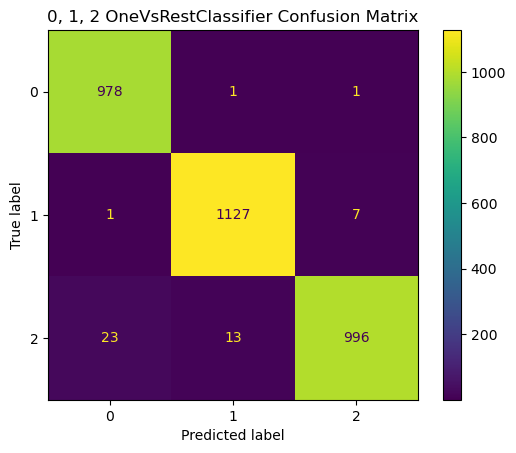

In [161]:
OneVsRest = OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='lbfgs'))
fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, OneVsRest)

(2b) Perform $\textbf{multinomial}$ logistic regression with the three digits {0,1,2} and report the overall test error.

0, 1, 2 -> Multinomial Test Score: 98.89%
0, 1, 2 -> Multinomial Test Error: 1.11%


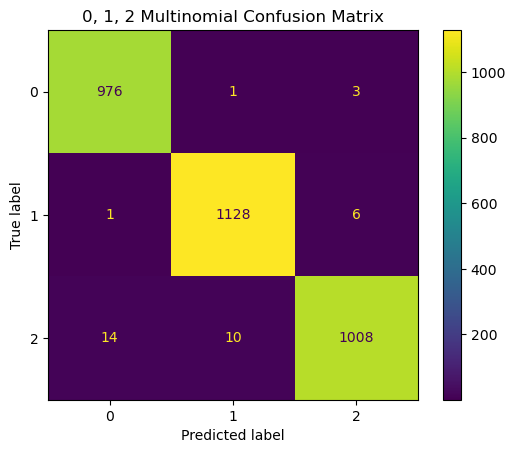

In [162]:
Multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs')
fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, Multinomial)

(2c) Perform the $\textbf{one-versus-one}$ multiclass logistic regression on the three digits {0,1,2} and report the overall test error. You will need to implment this extension from scratch first.

0, 1, 2 -> OneVsOneClassifier Test Score: 98.82%
0, 1, 2 -> OneVsOneClassifier Test Error: 1.18%


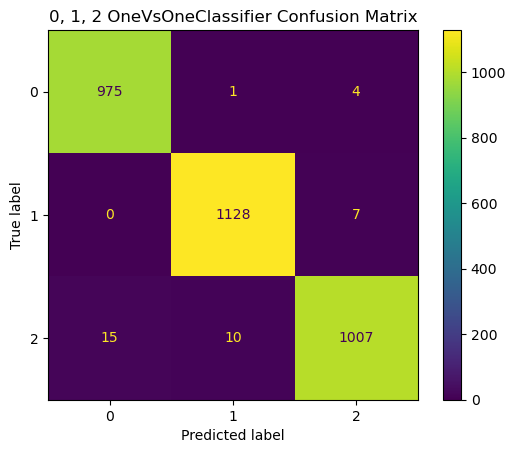

In [163]:
OneVsOne = OneVsOneClassifier(LogisticRegression(solver='lbfgs'))
fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, OneVsOne)

(2d) Which combination of three digits do you think are the hardest to distinguish? Perform each of the three extensions of multiclass logistic regression with those images (training and test) and report the overall test errors (using a bar plot).

## (3) Classify all 10 digits simultaneously

Perform each of the three extensions of multiclass logistic regression with the full data set and report the overall test errors (using a bar plot).

Summarize your findings by commenting on which version of multiclass logistic regression works the best on the handwritten digits dataset and which digits are the hardest to be distinguished from the rest.